# Format the Hyades data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits

plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 40,
           'xtick.labelsize': 40,
           'ytick.labelsize': 40,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [2]:
hy1 = pd.read_csv("data/hyades_douglas.csv", skiprows=77)
hy1.head()

,[RSP2011],HIP,RAJ2000,DEJ2000,2MASS,EPIC,Kpmag,Mass,Bin,Ap,...,I99.9,Q,mPer,use,K2Per,K2Pw,Amp,Ng,Bl,Lit
0,64,,03 34 10.5,+22 04 21.2,03341053+2204213,210942999,13.68,0.17,2,4.0,...,0.0094,0,N,corr,1.8088,0.8608,0.008264,Y,N,1
1,,,03 40 45.8,+17 34 47.7,03404581+1734477,210643507,16.64,0.13,0,3.0,...,0.0091,2,N,corr,,,0.020290,N,N,0
2,75,,03 42 04.4,+16 25 18.3,03420441+1625183,210563410,15.13,0.18,0,2.0,...,0.0083,2,N,corr,,,0.158637,Y,Y,0
3,78,,03 43 47.0,+20 51 36.4,03434706+2051363,210865372,13.38,0.32,0,2.5,...,0.0091,0,N,corr,12.3168,0.6320,0.014581,Y,N,0
4,80,,03 46 59.5,+15 24 16.8,03465952+1524170,210499476,14.16,0.18,2,4.0,...,0.0098,0,N,corr,0.8584,0.7517,0.005815,N,N,1


Load the catalog of confirmed binaries.

In [3]:
bi = pd.read_csv("data/hyades_binaries.csv", skiprows=53)
epics, binary = [], []
for i in range(len(bi)):
    try:
        epics.append(int(bi.EPIC.values[i]))
        binary.append(bi["Conf?"].values[i])
    except ValueError:
        pass
    
bi1 = pd.DataFrame(dict({"EPIC": np.array(epics), "Binary": np.array(binary)}))
hy = pd.merge(hy1, bi1, on="EPIC", how="outer")

Convert RA and dec to degrees and reformat rotation periods.

In [4]:
from astropy import units as u
from astropy.coordinates import SkyCoord

ra, dec = [np.zeros(len(hy)) for i in range(2)]
for i in range(len(hy)):
    radec = "{0} {1}".format(hy.RAJ2000[i], hy.DEJ2000[i])
    c = SkyCoord(radec, unit=(u.hourangle, u.deg))
    ra[i] = c.ra.deg
    dec[i] = c.dec.deg
    
hy["RA_deg"] = ra
hy["DE_deg"] = dec

# print(hy.K2Per.values)
prots = np.zeros(len(hy))
for i, p in enumerate(hy.K2Per.values):
    try:
        prots[i] = float(p)
    except ValueError:
        pass
    
hy["prot"] = np.array(prots)
hy = hy.iloc[hy.prot.values > 0.]

Load the Bedell Gaia-K2 crossmatch (downloaded from gaia-kepler.fun) and ensmallen it so it's a managable size.

In [5]:
with fits.open('data/k2_dr2_1arcsec.fits') as data:
    bedell = pd.DataFrame(data[1].data)

In [6]:
c4_mask = bedell.k2_campaign_str.values == "4"

Calculate uncertainties on Gaia magnitudes.

In [8]:
from tools import photometric_noise
G_err, bp_err, rp_err, _ = photometric_noise(bedell.phot_g_mean_mag.values[c4_mask],
                                             bedell.phot_bp_mean_mag.values[c4_mask],
                                             bedell.phot_rp_mean_mag.values[c4_mask])

/Users/rangus/projects/stardate/paper/code/tools.py:19: RuntimeWarning: invalid value encountered in less
  bright = c < 13
/Users/rangus/projects/stardate/paper/code/tools.py:20: RuntimeWarning: invalid value encountered in greater
  medium = (13 < c) * (c < 17)
/Users/rangus/projects/stardate/paper/code/tools.py:20: RuntimeWarning: invalid value encountered in less
  medium = (13 < c) * (c < 17)
/Users/rangus/projects/stardate/paper/code/tools.py:21: RuntimeWarning: invalid value encountered in greater_equal
  faint = 17 <= c


Save mini dataframe as csv file.

In [9]:
c4 = pd.DataFrame(dict({"source_id": bedell.source_id.values[c4_mask], 
                        "EPIC": bedell.epic_number.values[c4_mask], 
                        "ra": bedell.ra.values[c4_mask], 
                        "dec": bedell.dec.values[c4_mask], 
                        "G": bedell.phot_g_mean_mag.values[c4_mask],
                        "G_err": G_err,
                        "bp": bedell.phot_bp_mean_mag.values[c4_mask],
                        "bp_err": bp_err,
                        "rp": bedell.phot_rp_mean_mag.values[c4_mask],
                        "rp_err": rp_err,
                        "parallax": bedell.parallax.values[c4_mask],
                        "parallax_err": bedell.parallax_error.values[c4_mask],
                       }))
c4.to_csv("data/c4_gaia.csv")

Text(0, 0.5, '$\\mathrm{Dec}$')

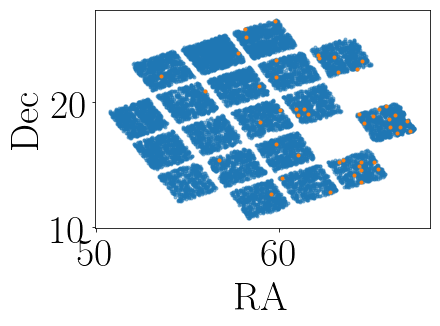

In [10]:
plt.plot(c4.ra, c4.dec, ".", alpha=.5)
plt.plot(hy.RA_deg, hy.DE_deg, ".")
plt.xlabel("$\mathrm{RA}$")
plt.ylabel("$\mathrm{Dec}$")

Just plot the crossmatched stars.

In [11]:
df = pd.merge(c4, hy, on="EPIC", how="inner")
df.drop_duplicates("EPIC", inplace=True)

Text(0, 0.5, '$\\mathrm{Dec}$')

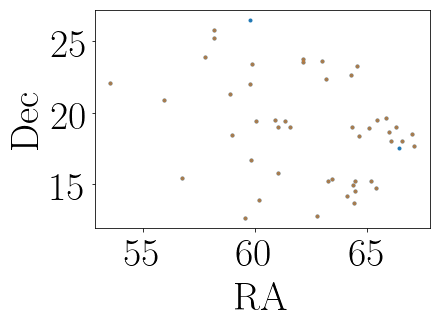

In [12]:
plt.plot(hy.RA_deg, hy.DE_deg, ".")
plt.plot(df.ra, df.dec, ".", alpha=.5)
plt.xlabel("$\mathrm{RA}$")
plt.ylabel("$\mathrm{Dec}$")

/Users/rangus/projects/stardate/stardate/lhf.py:66: RuntimeWarning: divide by zero encountered in log10
  log10_bprp = np.log10(bprp)


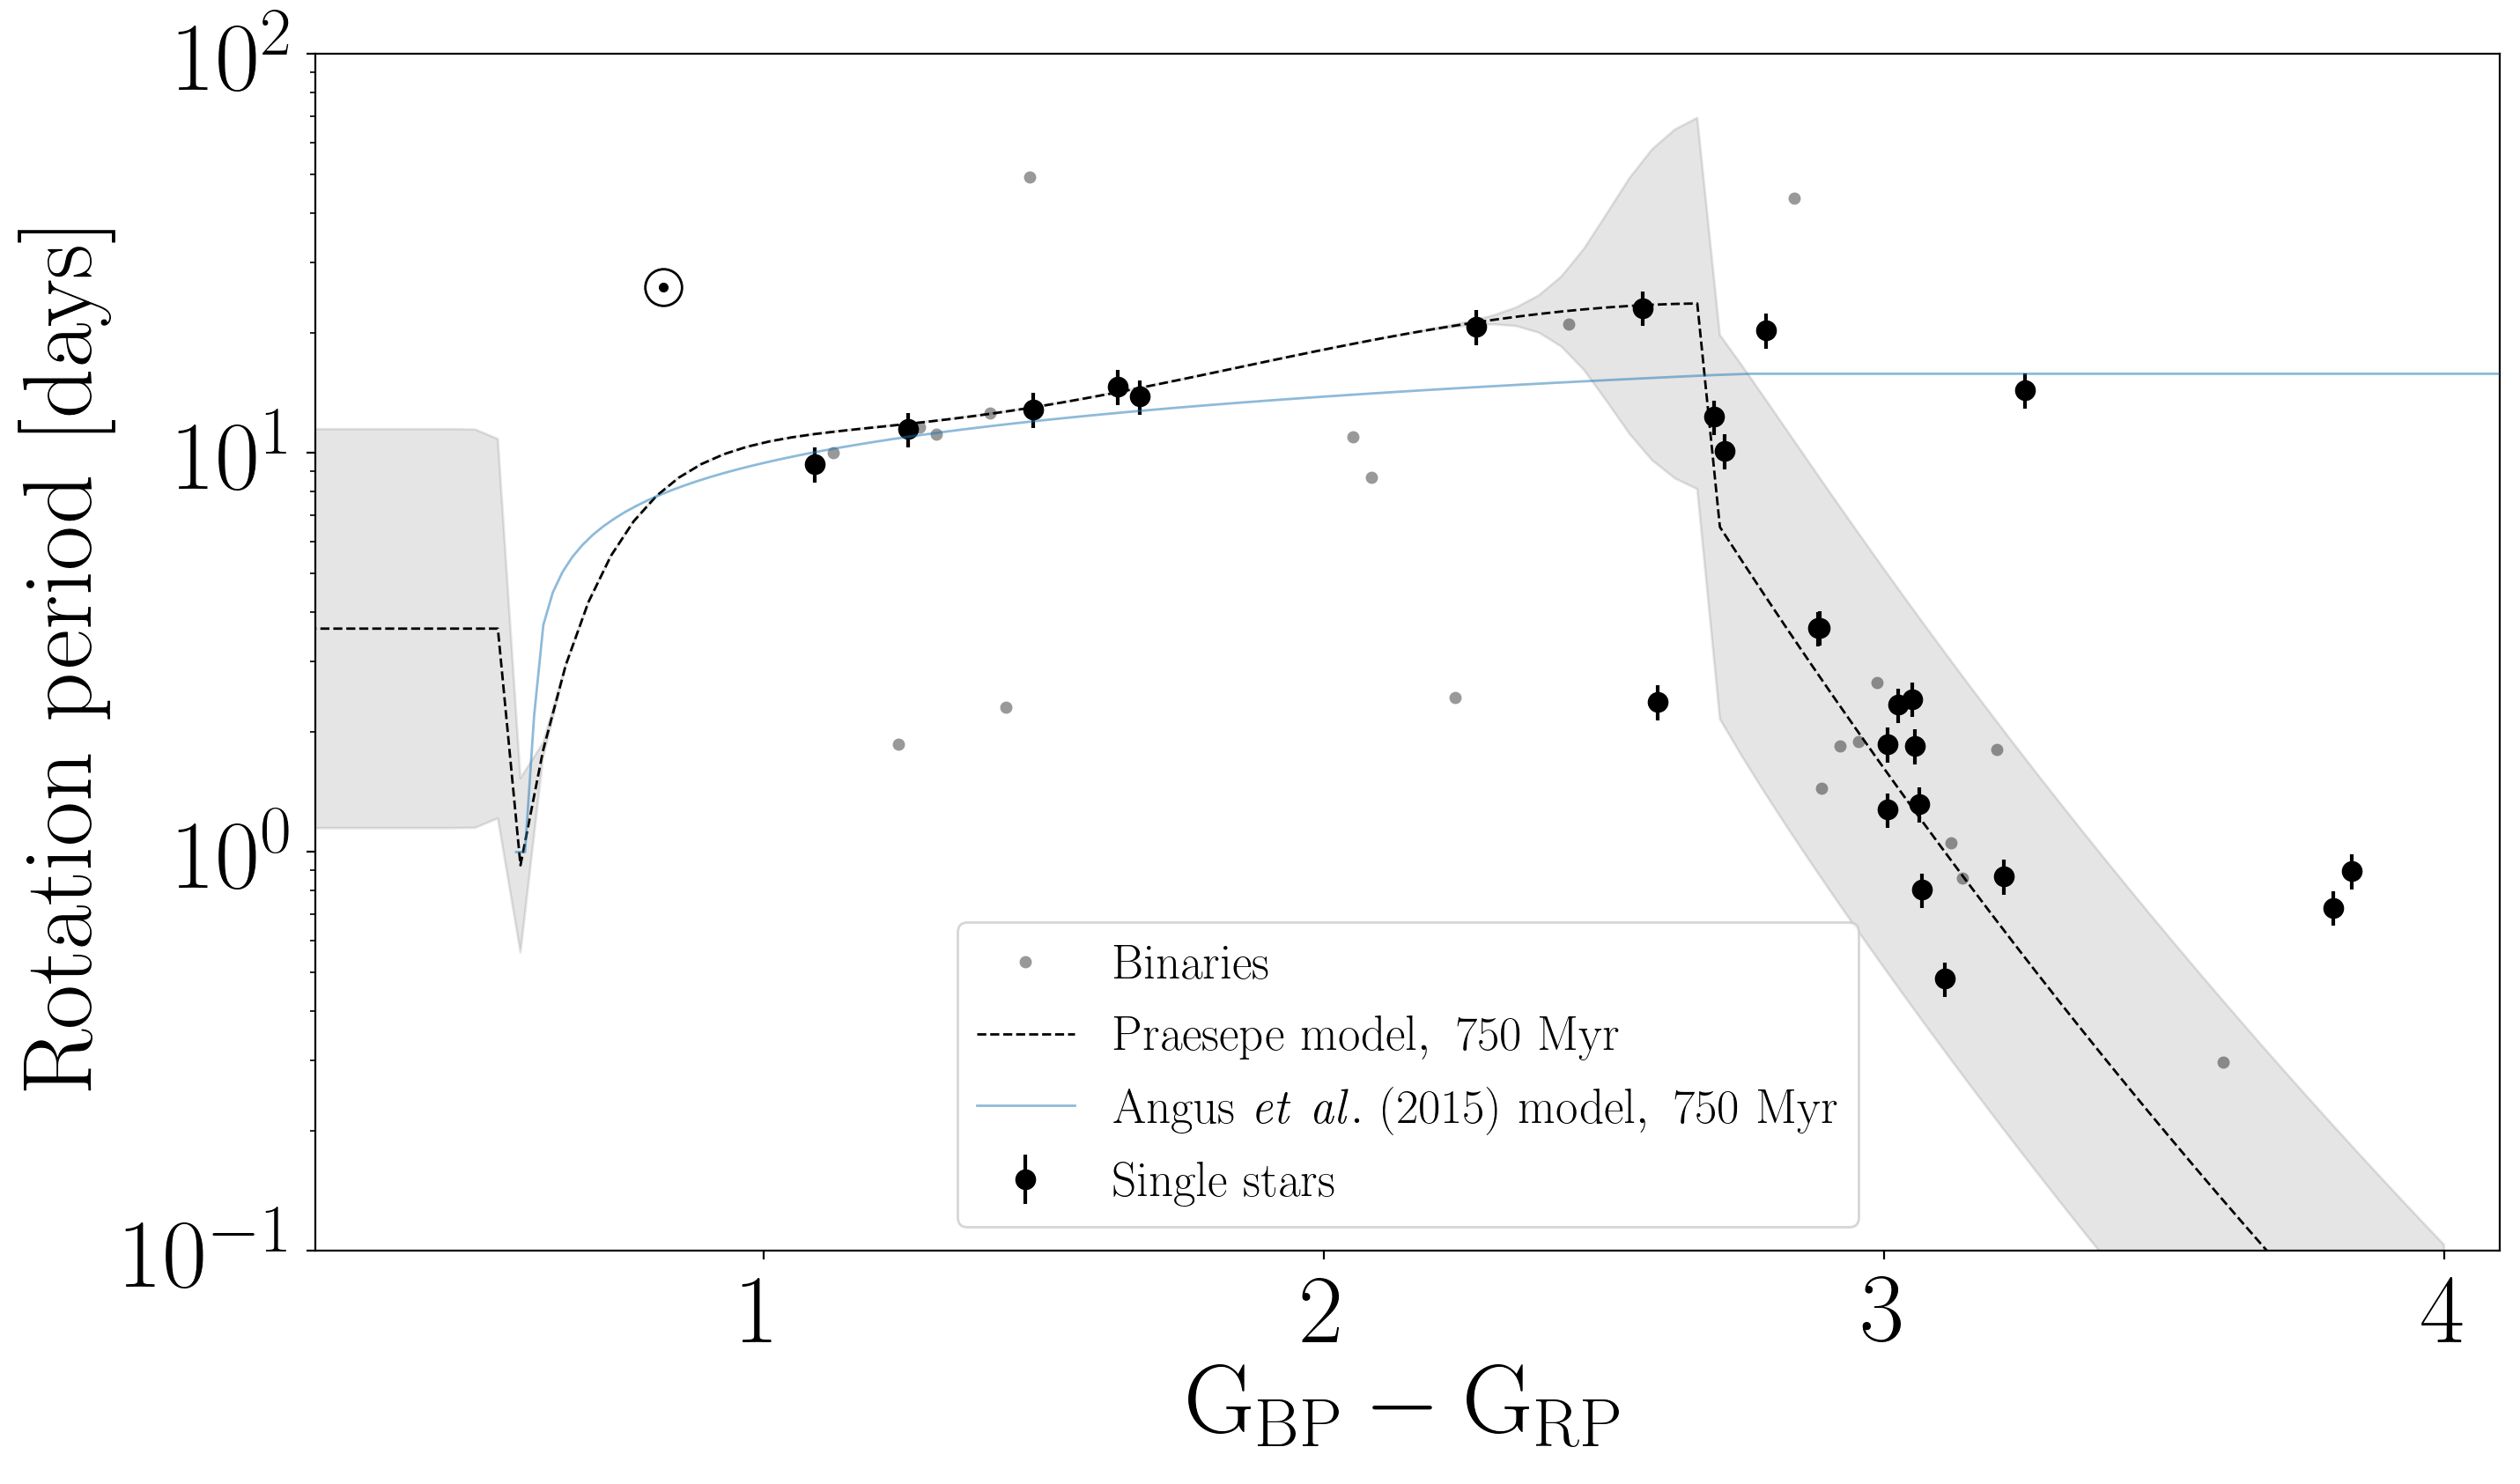

In [33]:
plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 20,
           'xtick.labelsize': 40,
           'ytick.labelsize': 40,
           'text.usetex': True}
plt.rcParams.update(plotpar)

import stardate.lhf as sdl

plt.figure(figsize=(16, 9), dpi=200)

binary = df.Binary.values == "Y"
plt.errorbar(df.bp[~binary] - df.rp[~binary], df.prot[~binary], 
             yerr=.1*df.prot[~binary], fmt="k.", ms=15, zorder=1,
             label="$\mathrm{Single~stars}$")

# Plot confirmed binaries
plt.plot(df.bp[binary] - df.rp[binary], df.prot[binary], ".", color=".6", ms=8, zorder=0,
         label="$\mathrm{Binaries}$")

from tools import bprp_2_bv
import stardate.lhf as sdl

# Plot Praesepe model
xs = np.linspace(0, 4, 100)
log_periods_praesepe, log_periods_sun, log_sigs = [np.zeros_like(xs) for i in range(3)]
for i, _x in enumerate(xs):
    log_periods_praesepe[i] = sdl.gyro_model_praesepe(np.log10(750*1e6), _x)
    log_periods_sun[i] = sdl.gyro_model_praesepe(np.log10(4.56*1e9), _x)
    log_sigs[i] = sdl.sigma(355, 9, 0., _x, model="praesepe")
    

plt.plot(xs, 10**log_periods_praesepe, color="k", lw=1, ls="--", zorder=3, ms=35, rasterized=True,
        label="$\mathrm{Praesepe~model,~750~Myr}$")
plt.fill_between(xs, 10**(log_periods_praesepe - log_sigs), 
                 10**(log_periods_praesepe + log_sigs), color="k", alpha=.1, rasterized=True)
# plt.plot(xs, 10**log_periods_sun, color="k", lw=1, ls="--", zorder=0, rasterized=True)
# plt.fill_between(xs, 10**(log_periods_sun - log_sigs), 
#                  10**(log_periods_sun + log_sigs), color="k", alpha=.1, rasterized=True)


# Plot Angus (2015) model.
xs = np.linspace(-.15, .8, 100)
bv, log_periods_praesepe, log_periods_sun, log_sigs = [np.zeros_like(xs) for i in range(4)]
for i, _x in enumerate(xs):
    bv[i] = bprp_2_bv(10**_x)
    log_periods_praesepe[i] = sdl.gyro_model(np.log10(625*1e6), bv[i])
    log_periods_sun[i] = sdl.gyro_model(np.log10(4.56*1e9), bv[i])
    log_sigs[i] = sdl.sigma(355, 9, 0, bv[i])

plt.plot(10**xs-.15, 10**log_periods_praesepe, color="C0", lw=1, zorder=3, ms=35, rasterized=True,
        label="$\mathrm{Angus~{\it et~al.}~(2015)~model,~750~Myr}$", alpha=.5)
# plt.plot(10**xs-.15, 10**log_periods_sun, color="C0", lw=1, zorder=0, rasterized=True,
#          , alpha=.5)

plt.plot(.82, 26, "wo", markeredgecolor="k", ms=15, zorder=3, rasterized=True)
plt.plot(.82, 26, ".k", zorder=3, rasterized=True)

plt.yscale("log")
plt.ylim(.1, 100)
plt.xlim(.2, 4.1)
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.legend(loc="lower center")
plt.savefig("../hyades.pdf")

In [17]:
df.to_csv("data/hyades.csv")
df_singles = df.iloc[~binary]
df_singles.to_csv("data/hyades_single.csv")

In [35]:
from tools import read_files

age_samps, ages, errp, errm, std, inds = read_files("praesepe_stardate", df_singles.EPIC.values,
                                                    "hyades_results", zf=9)
bprps = df_singles.bp.values[inds] - df_singles.rp.values[inds]

age_samps_i, ages_i, errp_i, errm_i, std_i, inds_i = read_files("iso", df_singles.EPIC.values,
                                                    "hyades_results", zf=9)
bprps_i = df_singles.bp.values[inds_i] - df_singles.rp.values[inds_i]

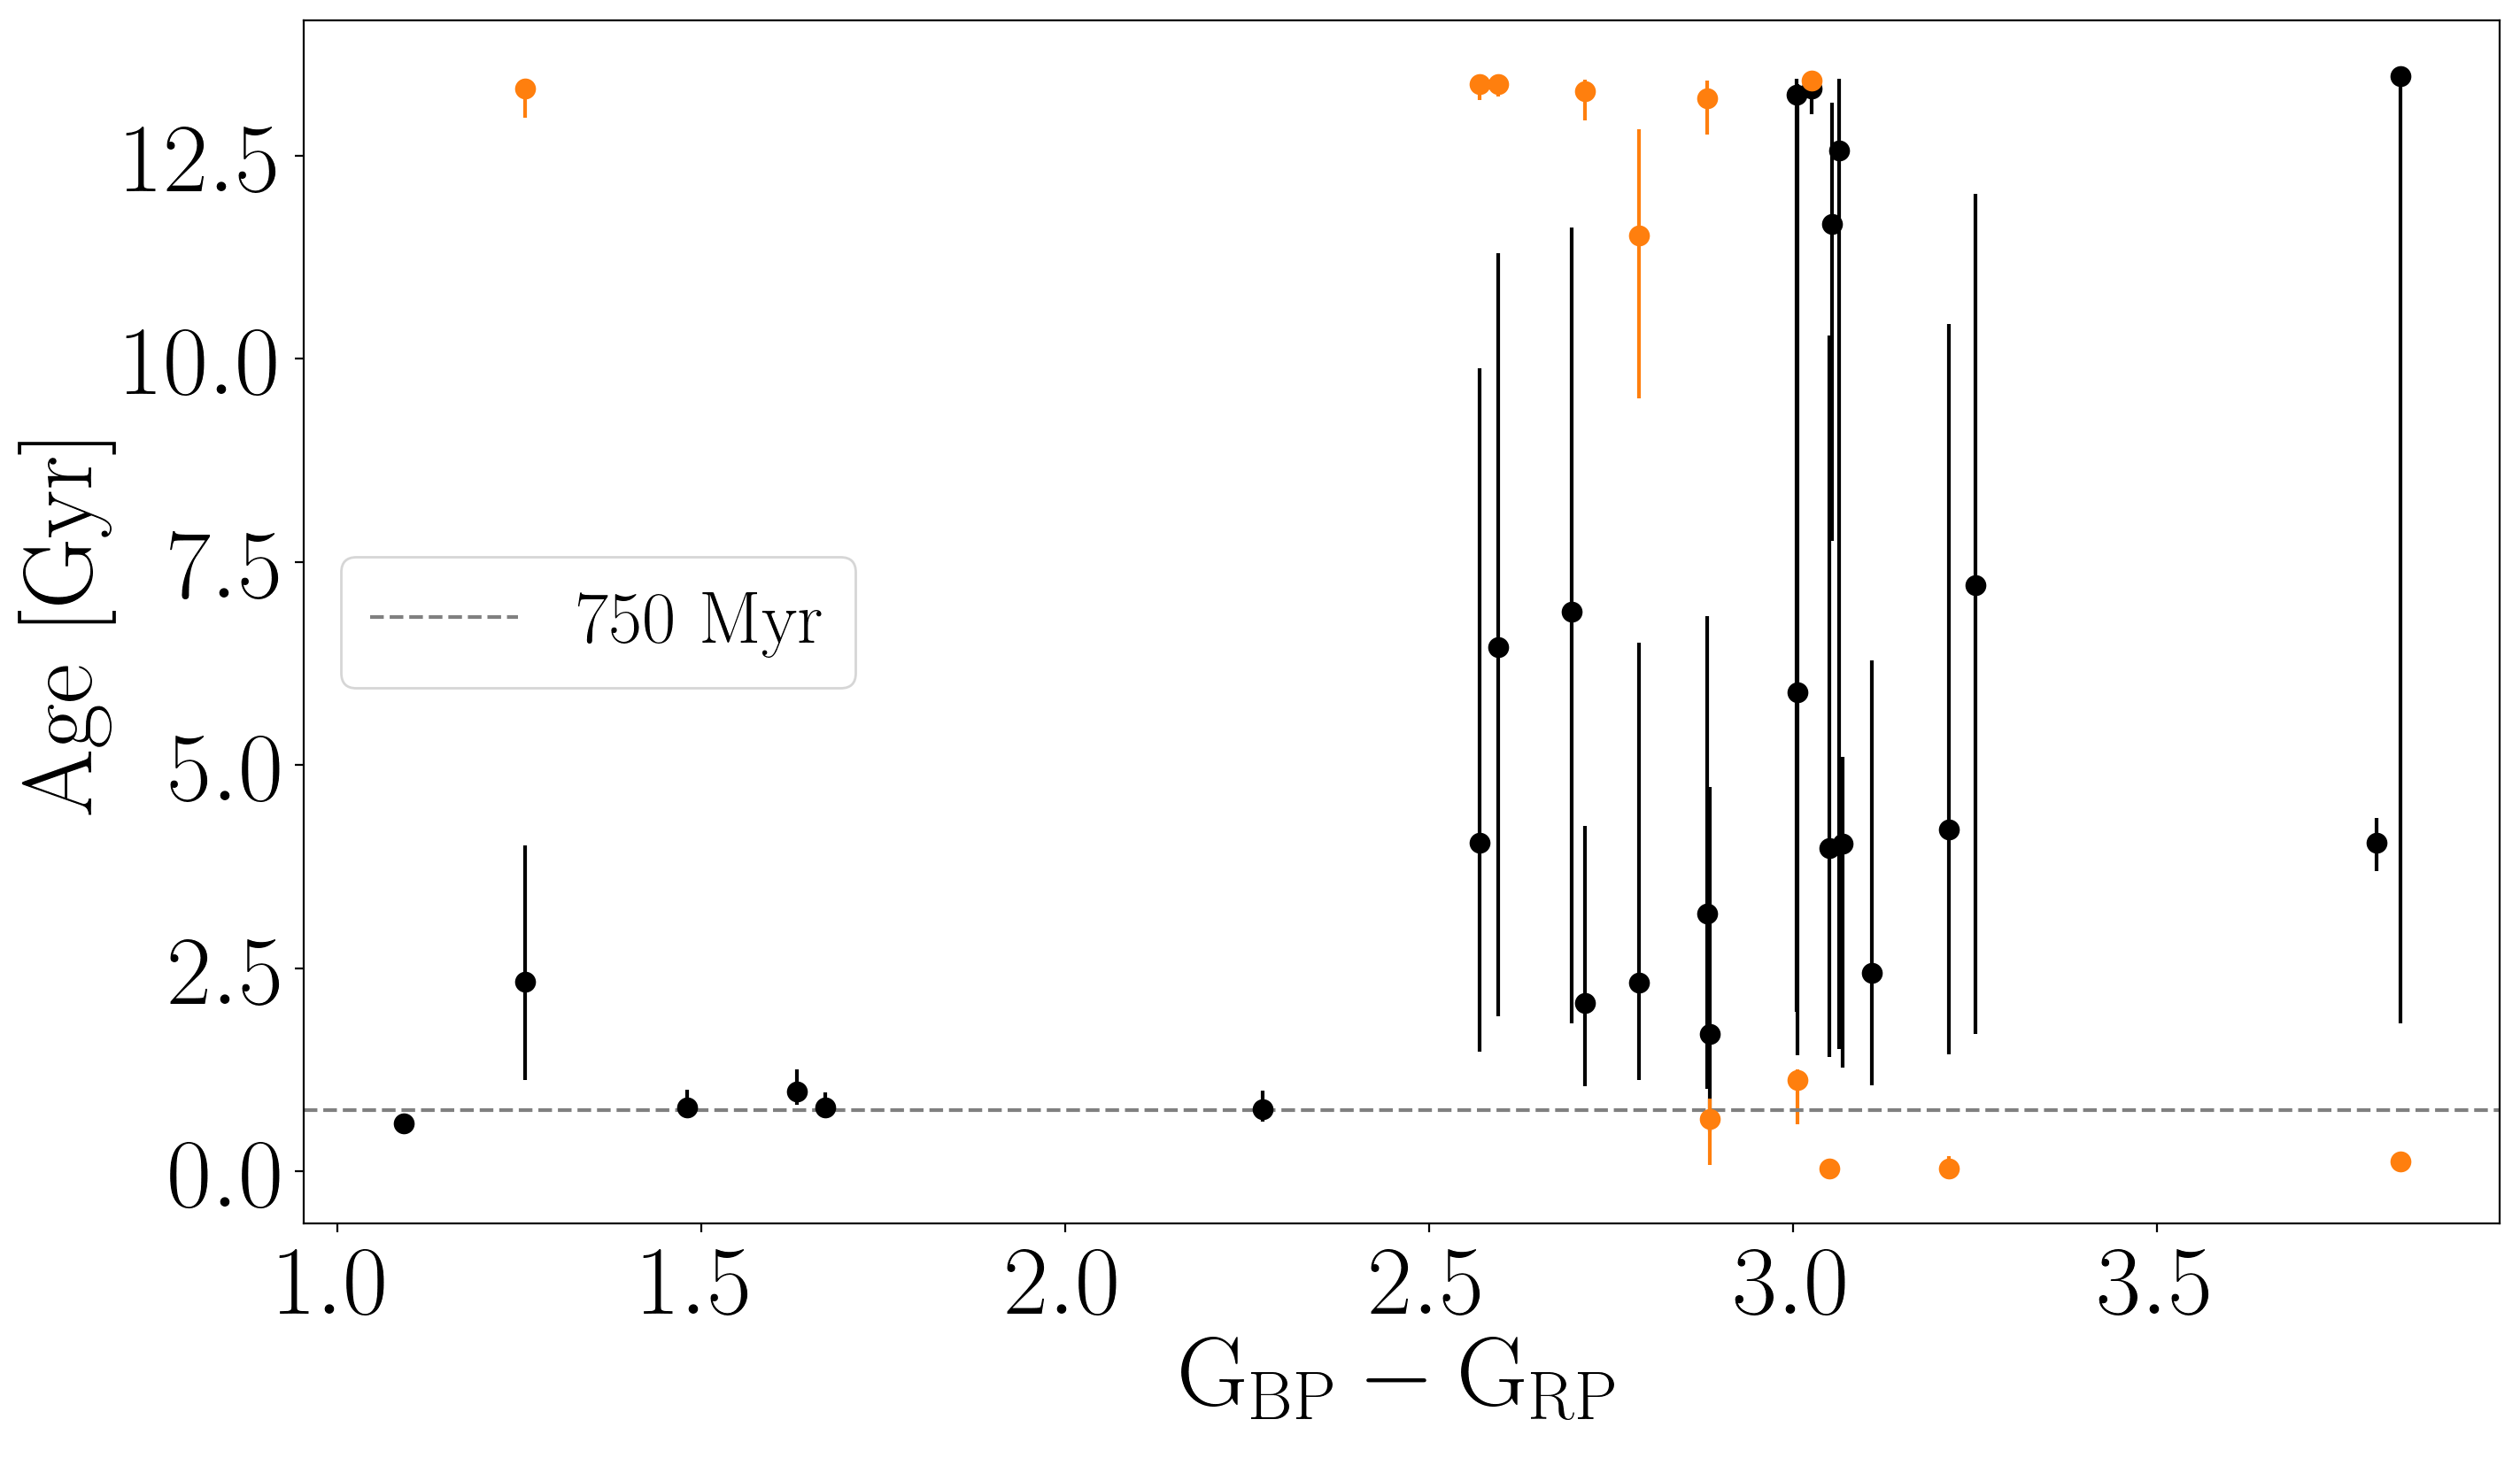

In [37]:
plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 40,
           'ytick.labelsize': 40,
           'text.usetex': True}
plt.rcParams.update(plotpar)

plt.figure(figsize=(16, 9), dpi=200)
plt.errorbar(bprps, ages, yerr=[errm, errp], fmt="k.", ms=15)
plt.errorbar(bprps_i, ages_i, yerr=[errm_i, errp_i], fmt=".", color="C1", ms=15)
plt.axhline(.75, color=".5", ls="--", label="$\mathrm{750~Myr}$")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{Age~[Gyr]}$")
plt.legend()
plt.savefig("../hyades_results.pdf")